# Simple Time Series (Stock Prices)

# Setup

In [ ]:
#| code-fold: true
from fastcore.all import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from datetime import timedelta
from utils import view_source_code

In [ ]:
path = Path('../data')

# Overview

In this post we will use recent stock price history to make buy and sell decisions.  This is intended to be a first step in exploring quant trading.  Because we believe in learning by doing, we will be building trading strategies!

Before diving into the technical bits, it is *always* a good idea to take the time to think about things at a high level and why your idea might work.  We can generate ideas *much* faster than we can code and test them, so we need to use intuition and experience to help guide us in which ideas we want to prioritize.  Intuition is important and where I start - but intuition is not reliable enough on it's own - we **must** then turn intuition into code with rigorous testing before we can decide whether to implement the strategy.  .

# Intuition

## Belief

I believe how a company is doing over the last month can be used to predict how how well it will do in the future.  This isn't much of a leap, but let's think about a few reasons as to why this may be true.

+ **Available Capital:** If a company is doing well, it typically means they have more profit.  More profit means more that can be reinvested.  More reinvestment can mean faster growth.

+ **Economies of Scale:** Often the more successful a company is the more they can drive down cost in some areas.  For example, General Mills can buy sugar at a lower price than a small business due to their buying power.  As buying power increase, they can leverage that to drive down costs.
    
+ **Brand Recognition:** The more successful a business is and the larger it grows, the more brand recognition it has.  The more brand recognition it has the more it can leverage it's brand to grow.

## Hypothesis

The *hypothesis* for this post is that recent stock performance can be used on its own to predict future stock performance.  Regardless of how much we believe that to be true, we should not trade based on this belief until we have evidence.  This post will explore several options for using this hypothesis to make trades.

[The next post](../Statistics/BasicTesting.ipynb) will give a foundation in testing and show how we can test and evaluate how well these approaches perform and determine if these are ideas worth keeping.

# The Data

## Load data

First let's take a look at the data we will be using and talk a bit about it.

In [ ]:
raw = pd.read_csv(path/'eod-quotemedia.csv',parse_dates=['date'])
raw.head(3)

,date,ticker,adj_close
0,2013-07-01,A,29.994186
1,2013-07-02,A,29.650137
2,2013-07-03,A,29.705185


In [ ]:
L(*raw.ticker.unique())

(#495) ['A','AAL','AAP','AAPL','ABBV','ABC','ABT','ACN','ADBE','ADI'...]

We can see that for each day we have a ticker.

:::{.callout-tip} 

A ticker is a symbol associated with a company.  For example Apple has the ticker `AAPL`.  To buy shares in Apple you would buy `AAPL`.
:::

For each of these day|ticker combinations we have an `adj_close`, or adjusted close price.  After every transaction, the price of a stock changes slightly.  The `adjusted close price` is the last stock price of the day.  While this is not as detailed as having the price at a more granular level (second, minute, hour, etc.), called `tick` data, we can use daily close price to test many types of strategies.

::{note} This is the stock price for the ticker.  `adjusted` means that the prices have been adjusted to account for various actions, such as stock splits (more discussion on this later).  `close` means that it is the price at close of market.  

A good first step after getting tabular data is to use pandas' describe method.  As we do this we see a few good pieces of information to keep in mind:
+ Overall size of dataset - 409K rows
+ Very big range in values (~1 - ~1K), which most of them before $100

In [ ]:
raw.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
adj_close,490737.0,75.100472,75.438804,1.59,36.782424,57.499593,87.4,1011.34


## Null Values

Let's take a look and make sure we don't have any null values to handle.  This is one of those things you need to do with every dataset.  This is also a great opportunity to show how you can add in simple tests into your code as you go using an `assert` statement, which will help you catch issues as you iterate and change things.

In [ ]:
assert np.array([o==0 for o in raw.isnull().sum()]).all() == True

## Survivorship bias

We also want to take a quick look at the non-numeric columns to get an idea of what time frame we have and how many tickers.  This is often known from the dataset, but it is good practice to look at the dataset and ensure that your understanding of the dataset aligns with what you see in the data. 

In [ ]:
print(f"Date column contains dates from {raw.date.min().date()} to {raw.date.max().date()}")

Date column contains dates from 2013-07-01 to 2017-06-30


Let's see if all tickers in the dataset have the same start and end date.

In [ ]:
ticker_cnt = len(raw.ticker.unique())

_min = raw[['ticker','date']].groupby('ticker').min()
_min = _min[_min.date != '2013-07-01'].count().date

_max = raw[['ticker','date']].groupby('ticker').max()
_max = _max[_max.date != '2017-06-30'].count().date

print(f'''Out of {ticker_cnt} tickers:
  + 20 do do not start on 2013-07-01
  + 0 do not have an entry for 2017-06-30''')

Out of 495 tickers:
  + 20 do do not start on 2013-07-01
  + 0 do not have an entry for 2017-06-30


Good thing we checked!  Let's think through what these two data points mean:

+ **20 do do not start on 2013-07-01:**  This makes sense because some of the companies may not have been founded or fit our criteria until after the start date of the dataset.  Maybe they were private companies that went public, or maybe they grew to a large enough size to be part of our universe.
+ **0 do not have an entry for 2017-06-30:**  While it's not definitive proof of an issue, it is cause for concern.  This dataset may have a survivorship bias built in.  Let's talk about what survivorship bias is and why this could be a problem.

In our dataset we see that every ticker has a close price on the last day of the dataset.  This means that all of the companies are active at the end of our dataset.  What this means is that either:

+ No company went out of business or failed in our universe between our July 2013 and June 2017 dates
+ Some companies did fail during our universe time period and our dataset does not reflect that.

While either are possible, the second option is a common problem.  Let's talk about why failed companies not being a part of our universe is a problem.

Let's say I look at the S&P 500 companies in 2022 and build a dataset of their stock prices for 2015 - 2022. We want to tests how well a strategy would have performed in that time range.  Any trade has many outcomes for example:

1. You could buy a stock and then the company goes out of business and you lose lots of money
2. You could buy a stock and then the price goes up and you profit
3. You could buy a stock and then the price goes down and you lose money

The problem is that option #1 is **impossible** in this dataset.  We know none of the business went out of business between 2015 and 2022 because they were all in the S&P 500 in 2022.  Option #1 is more likely than it should be because we already know the companies on the list are among the largest companies in 2022, so regardless of what company we pick we know it ends up a large company.  Option #3 is less likely than it should be because if a company shrunk in size to the point it's not in the S&P 500 in 2022 it's not even in the dataset.  Our strategies may perform extremely well on our dataset, but when we run it on real data with real money we could be in for a shock!

Bottom line is we need **point in time** data, or rather data for a given date should only be as accurate as you could have known on that date.

When we see all tickers in the universe have a stock price on the last day, it's important to verify that this did not happen in your dataset.  When we talk about testing later, we will talk about how we can test to ensure we have accurate results.

## Reformat

Now that we have an basic idea of what's in our data we can reformat it to a format that will be easier to use for analysis.  For what we are doing we will be applying things based on ticker, so let's give each ticker it's own column.

In [ ]:
df = raw.pivot(index='date', columns='ticker',values='adj_close')
df.iloc[:,:5].head(3)

ticker,A,AAL,AAP,AAPL,ABBV
date,,,,,
2013-07-01,29.994186,16.176093,81.138217,53.109173,34.924478
2013-07-02,29.650137,15.819834,80.722073,54.312247,35.428076
2013-07-03,29.705185,16.127950,81.237299,54.612043,35.444862


We can use the same describe as above to see statistics about each ticker.

In [ ]:
df.iloc[:,:5].describe()

ticker,A,AAL,AAP,AAPL,ABBV
count,1009.000000,1009.000000,1009.000000,1009.000000,1009.000000
mean,40.983757,37.811501,141.576280,100.360320,52.977953
std,5.850163,8.816410,26.260390,22.660593,7.897264
min,29.650137,14.770314,78.393647,53.109173,34.924478
25%,37.656517,34.383874,125.561609,87.186576,46.981317
50%,39.700762,39.218491,147.450711,102.884811,53.983957
75%,43.944859,43.681272,159.019446,114.257784,59.212432
max,60.131015,54.071539,199.374304,153.694280,70.780784


## Validation Set

We are going to split our data into 2 groups.  This way we have a secondary unseen dataset to test my strategies.  I want to develop models on one set of data but evaluate them on different data.  This may not seem important but it is absolutely crucial and perhaps the most important concept.  The more complex your model and analysis the more important this becomes.  This will be discussed in much greater detail in [the next post]((../Statistics/BasicTesting.ipynb), but for now just take my word for it.

With time series you generally want your validation set to be the most recent data.  This reflects reality best; creating a model on data with the intent to use it on future data.

In [ ]:
train = df.loc[:pd.Timestamp('2017-1-1 01:00:00')]
valid = df.loc[pd.Timestamp('2017-1-1 01:00:00'):]

In [ ]:
print(f"Train Dates: {train.index.min().date()} thru {train.index.max().date()}")
print(f"Valid Dates: {valid.index.min().date()} thru {valid.index.max().date()}")

Train Dates: 2013-07-01 thru 2016-12-30
Valid Dates: 2017-01-03 thru 2017-06-30


# Models

## Basic Momentum

As our first model let's use percent change over recent stock price history.  We will take the percent difference between the current stock price and the stock price from a set time in the past.  As we think about this approach there are several levers we can pull time find tune our approach:

+ **Time Range:** We could use the past 5 days, or past 30 days, or the past year.  How far back should we be comparing?
+ **Threshold:** What threshold do we need to cross before we consider it momentous enough to take an action?  Is a 1%, 5%, 10%?
+ **What action?**  Is it just buy and sell?  Could we use this to short?
+ **When do we close our position**  Is it a set time period?  Or based on another threshold?

We will use 28 days for the time range and 8% for our threshold in this example to demonstrate the concept, but in the testing section we will show how to test different parameters.

In [ ]:
from SimpleTimeSeries import get_momentum_actions
view_source_code(get_momentum_actions)

In [ ]:
actions = get_momentum_actions(train.iloc[:,:5],n_periods=28,threshold=0.08)
actions.head(10)

ticker,A,AAL,AAP,AAPL,ABBV
date,,,,,
2013-08-10,,Buy,,Buy,Buy
2013-08-13,,Buy,,Buy,
2013-08-14,Buy,,,Buy,
2013-08-15,,,,Buy,
2013-08-16,,,,Buy,
2013-08-17,,,,Buy,
2013-08-20,,Short,,Buy,
2013-08-21,,Short,,Buy,
2013-08-22,,Short,,Buy,


This leaves us with a table of what actions we are going to execute each day for each stock.  Let's look at some other options for using this momentum-esque concept, and then we can test them all and compare how they perform at the end.

## Regression Momentum

Our previous approach was just the percent change between 2 dates.  But what if one of those days is an outlier?  Should we really make a decision based on just 2 data points?  To address this concerns we will define momentum slightly differently with the slope of a fit regression.

First, let's understand the general concept better.  Creating these minimal examples and visuals is *not* just something educational for a post - you should do this in your own projects as well.  It will help you think more deeply about your problem.

Below I took the stock price for Apple in a 10 day period and plotted it as a scatter plot.  Every 4 data points I fit a regression trend line fit to them.  We can see that in some groups the trend a very aggressive upward slope, others it's more neutral, and in others it is a strong negative slope.  By using that slope we can determine how much momentum the group of points has.  In this way we use all the recent data points to influence momentum and not just the first and last in a period.

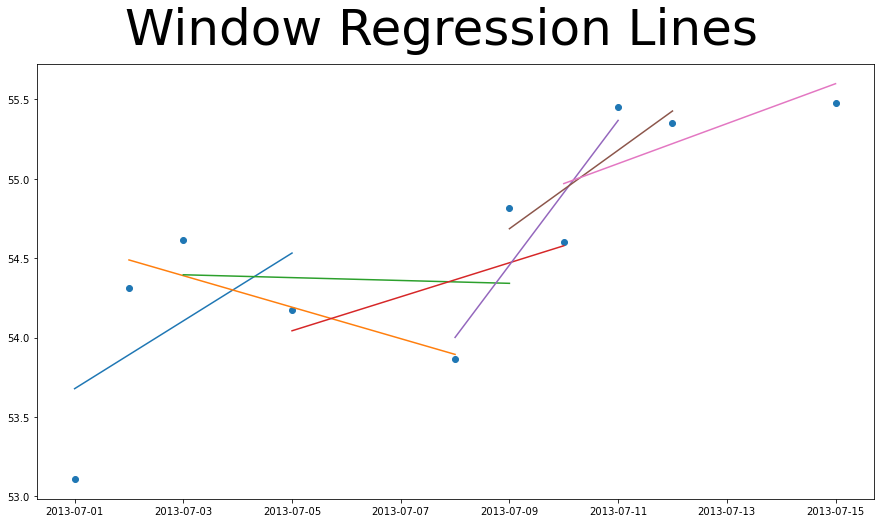

In [ ]:
# Create Figure
fig,ax = plt.subplots(figsize=(15,8))
fig.suptitle("Window Regression Lines",fontsize=50)

# Get 10 data points
_ = train['AAPL'].iloc[:10] 

x1 = _.index.day.values
y1 = _.values

sz = 4 # Window Size

# Get Windows for x and y
regr_y = [y1[i:i+sz] for i in range(0,len(y1)-(sz-1))]
regr_x = [x1[i:i+sz].reshape(-1, 1) for i in range(0,len(x1)-(sz-1))]

# Create Regression lines
regr = [LinearRegression().fit(x,y).predict(x) for x,y in zip(regr_x,regr_y)]

# Pad Regression Lines for Plotting
regr_padded = [[None]*i+list(r)+[None]*(len(x1)-sz-i) for i,r in enumerate(regr)]

# Plot
ax.scatter(_.index,y1)
for i in range(len(regr)): ax.plot(_.index,regr_padded[i])

plt.show()

So we take the slope of the trend line to be our momentum.  There are very similar levers as before we can change to fine tune out approach:

+ **Time Range:** We could use the past 5 days, or past 30 days, or the past year.  How far back should we be comparing?
+ **Threshold:** What threshold do we need to cross before we consider it momentous enough to take an action?  Is a slope of 1? Slope of 10?  Should we do something other than a set value?
+ **What action?**  Is it just buy and sell?  Could we use this to short?
+ **When do we close our position**  Is it a set time period?  Or based on another threshold?

We will use 28 days for the time range and $5 for our threshold in this example to demonstrate the concept, but in the testing section we will show how to test different parameters.

:::{.callout-note} 
We are assuming that every day is equally spaced in this regression.  I reality, the stock market is not open daily.  We are ignoring this for this analysis to keep things simple, but it may be something for us to revisit in a future post!
:::

In this section we are using a straight dollar threshold instead of a percentage.  This can cause difficulties because a ticker with a share price at 20 dollars increasing to 25 dollars is a HUGE increase.  If a stock goes from 500 to 505 dollars that is not nearly as big of a deal.  The point of this post is to show variety of options and get you thinking so we will keep this one as is and see how it shakes out when we test it the approach.

Let's codify our approach so we have a function we can use to test with later.

In [ ]:
from SimpleTimeSeries import get_momentum_regr_actions
view_source_code(get_momentum_regr_actions)

In [ ]:
actions = get_momentum_regr_actions(train.iloc[:,[3,-3,-8,1,30]],n_periods=28,threshold=.24)
actions.head(10)

ticker,AAPL,ZBH,XOM,AAL,ALXN
date,,,,,
2013-08-10,Buy,Buy,,,Buy
2013-08-13,Buy,Buy,,,Buy
2013-08-14,Buy,,,,Buy
2013-08-15,Buy,,,,Buy
2013-08-16,Buy,,,,Buy
2013-08-17,Buy,,,,
2013-08-20,Buy,,,,
2013-08-21,Buy,,,,
2013-08-22,Buy,,,,


## Bollinger Bands

A bollinger band uses a rolling standard deviation to determine when the stock price is unusually high or low.  In theory if the price is doing something unexpected we can capitalize on that.  So rather than a percent change, or a regression line, we are now picking it based on whether it's unusually high or low per the standard deviation.

Let's walk through graphing a bolldinger band this on a couple tickers so we understand what's going on.  Then we can figure out how to use this to create a trading strategy.

In [ ]:
from SimpleTimeSeries import calculate_bollinger
view_source_code(calculate_bollinger)

In [ ]:
calculate_bollinger(train,['AAPL','MSFT','GOOG','AMZN'])['AAPL'].sample(3)

,lower_band,raw,upper_band,lower_limit,upper_limit
date,,,,,
2016-07-08,89.498384,93.405487,97.142827,False,False
2014-10-02,91.353234,93.418008,96.999605,False,False
2016-12-06,104.282310,107.352218,111.253007,False,False


In [ ]:
from SimpleTimeSeries import plot_bollinger
view_source_code(plot_bollinger)

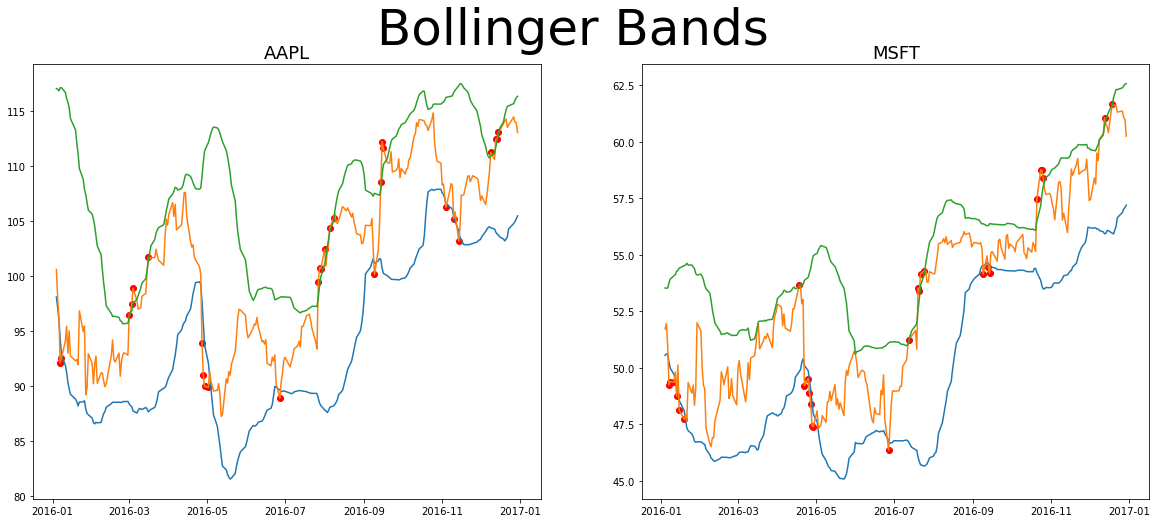

In [ ]:
plot_bollinger(calculate_bollinger(train),min_date='2016-01-01')

These charts show stock prices for Apple and Microsoft over time in orange.  The green is our upper band, which in this case is 2 standard deviations above the mean when looking at the last 28 days of the adjusted close price.  The blue is 2 standard deviations below the mean.

We've plotted red dots anywhere the stock price crosses these bounds.  This can only happen if there is a significant enough shift for it to be 2 standard deviations from the mean.  Let's code up this third momentum-esque approach as well so we have a 3rd method to test.  Where the price crosses a bollinger band we will take an action!

In [ ]:
from SimpleTimeSeries import get_bollinger_actions
view_source_code(get_bollinger_actions)

In [ ]:
actions = get_bollinger_actions(train.iloc[:,:5],window_sz=28,band_sz=2)
actions.head(10)

,A,AAL,AAP,AAPL,ABBV
date,,,,,
2013-08-10,,,,,
2013-08-13,,,,,
2013-08-14,,Short,Buy,Buy,
2013-08-15,,Short,,Buy,
2013-08-16,,Short,,Buy,
2013-08-17,,Short,Short,Buy,Short
2013-08-20,,Short,Short,Buy,
2013-08-21,,,,,Short
2013-08-22,,,,,Short


# Momentum Conclusion

In this post we took a simple idea of using recent stock price changes to define a trading strategy.  One key thing I hope you took is even with simple concepts there are many ways that it can be approached - we created three.  You **must** be able to think deeply about what your options are and experiment with different approaches and understand what are all the things in these approach you can control or tweak.  You **must** be able to take ideas and translate them to code.

There are many more trading strategies that could be done using the same concepts in this post.  I encourage you to come up with one and implement it yourself.  That will be more difficult than reading the post was, but you will also learn more by doing that.  Once you do that write an explanation of why it might work, what you could tweak, and post share it.  We'd love to see what you built!

Learn by building + write to learn = success


# What's next

In [the next post](../Statistics/BasicTesting.ipynb) we will introduce the most important and challenging topic in any predictive or modeling discipline, testing.  Effective testing is challenging and important because we need to be as confident as possible that the strategy we have will work "in the wild" just like we think it will.

There are many horror stories of models being put into production and because they were not properly tested they failed and lost the company tons of money.  When the tests performed do not provide an accurate view of how the model will perform in production, you've got a big problem.  Understanding testing is crucial to a quant to minimize these unexpected catastrophic failures.

# Homework for Further Learnings

Entry-Level
1. Run the models in this post with different parameters.  How does this effect the number of actions taken?
1. Create a `get_momentum_regr_actions` that is not (or less effected) by scale.  For example you could combine the slope concept from `get_momentum_regr_actions` with the percent change concept from `get_momentum_actions`.

Mid-Level
1. The models in this post gave actions to take to open a position (ie buy/short).  Come up with two ideas for how we could determine when to close the position.  If we bought a stock we must eventually close the position by selling it.  Code them up!
1. Decisions are made in code all the time and are not always explicitly highlighted as a design choice.  For example, in `get_momentum_actions` we used a threshold of 0.08.  What would the effect be if it were increased vs decreased?  How do you think that would impact your strategy?  Find 3 more design choices and explain the trade-offs.
